In [19]:
# 載入需要的套件
import os
import sys

import backtrader as bt
import pandas as pd
import pyfolio as pf

current_notebook_dir = os.getcwd()
project_root_path = os.path.dirname(os.path.dirname(current_notebook_dir))
sys.path.append(project_root_path)

import Chapter1.utils as chap1_utils
from datetime import datetime, timedelta

In [20]:
analysis_period_start_date = "2024-01-01"
analysis_period_end_date = (datetime.now()+timedelta(days=1)).strftime("%Y-%m-%d")
trade_start_date= "2024-11-08"

In [21]:
top_N_stocks = chap1_utils.get_top_stocks_by_market_value(
    excluded_industry=[
        "金融業",
        "金融保險業",
        "存託憑證",
        "建材營造",
    ],
    pre_list_date="2017-01-03",
)

In [22]:
# 取得指定股票代碼列表在給定日範圍內的美日 OHLCV 數據
all_stock_data = chap1_utils.get_daily_OHLCV_data(
    stock_symbols=top_N_stocks,
    start_date=analysis_period_start_date,
    end_date=analysis_period_end_date
)
all_stock_data["datetime"] = all_stock_data["datetime"].astype(str)
all_stock_data["asset"] = all_stock_data["asset"].astype(str)

/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:476: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd.DataFrame(yf.download(symbol, start=start_date, end=end_date)).droplevel(
[*********************100%***********************]  1 of 1 completed
/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:476: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd.DataFrame(yf.download(symbol, start=start_date, end=end_date)).droplevel(
[*********************100%***********************]  1 of 1 completed
/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:476: FutureWarning: YF.download() has changed argument auto_adjust default to True
  pd.DataFrame(yf.download(symbol, start=start_date, end=end_date)).droplevel(
[*********************100%***********************]  1 of 1 completed
/Users/houguanyu/Documents/code/python/stock/Q

In [23]:
# 指定各個季度下的因子組合和權重，用於排序和計算加權排名
select_rank_factor_dict = {
    f"{year}-Q{quarter}": [
        {"name": "營運現金流", "weight": 0.2},
        {"name": "歸屬母公司淨利", "weight": 0.2},
        {"name": "營業利益成長率", "weight": 0.2},
        {"name": "稅前淨利成長率", "weight": 0.2},
        {"name": "稅後淨利成長率", "weight": 0.2},
    ]
    for year in range(datetime.strptime(analysis_period_start_date, "%Y-%m-%d").year,
                      datetime.strptime(analysis_period_end_date, "%Y-%m-%d").year+1)
    for quarter in range(1, 5)
}


In [24]:
select_rank_factor_dict

{'2024-Q1': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],
 '2024-Q2': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],
 '2024-Q3': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],
 '2024-Q4': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],
 '2025-Q1': [{'name': '營運現金流', 'weight': 0.2},
  {'name': '歸屬母公司淨利', 'weight': 0.2},
  {'name': '營業利益成長率', 'weight': 0.2},
  {'name': '稅前淨利成長率', 'weight': 0.2},
  {'name': '稅後淨利成長率', 'weight': 0.2}],


In [25]:
# 列出所有會使用到的因子名稱
all_factors = []
for quarter, factor_pair in select_rank_factor_dict.items():
    for factor in factor_pair:
        all_factors.append(factor["name"])

all_factors = list(set(all_factors))
print(all_factors)

['營運現金流', '歸屬母公司淨利', '營業利益成長率', '稅前淨利成長率', '稅後淨利成長率']


In [26]:
# 取得所有遂使用到的因子數據
rank_factors_data_dict = {}
trading_days = pd.date_range(
    start=analysis_period_start_date, end=analysis_period_end_date
)
for factor in all_factors:
    # 取得因子數據，並按股票代碼和日期進行排序與填充
    quarter_factor_data = (
        chap1_utils.get_factor_data(
            stock_symbols=top_N_stocks,
            factor_name=factor,
            trading_days=list(trading_days)
        )
        .reset_index()
        .assign(factor_name=factor)
        .sort_values(by=["asset", "datetime"])
        .groupby("asset", group_keys=False)
        .apply(lambda group: group.ffill())
        .dropna()
    )

    # 根據因子值進行排序
    quarter_factor_data = chap1_utils.rank_stocks_by_factor(
        factor_df=quarter_factor_data,
        positive_corr=True,
        rank_column="value",
        rank_result_column="rank",
    ).drop(columns=["value"])
    rank_factors_data_dict[factor] = quarter_factor_data

/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_30558/562881947.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill())
/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_30558/562881947.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill())
/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_30558/562881947.py:18: 

In [27]:
# 計算每個季度的加權排名
all_factor_data = pd.DataFrame()
for quarter, factor_pair in select_rank_factor_dict.items():
    start_date, end_date = chap1_utils.convert_quarter_to_dates(quarter)
    trading_days = (
        pd.date_range(start=start_date, end=end_date).strftime("%Y-%m-%d")
    )

    # 取得當季因子的名稱與權重
    pairs = [x["name"] for x in factor_pair]
    weights = [x["weight"] for x in factor_pair]

    # 計算每個季度的加權排名
    quarter_factor_data = chap1_utils.calculate_weighted_rank(
        ranked_dfs=[
            rank_factors_data_dict[pairs[0]][
                (rank_factors_data_dict[pairs[0]]["datetime"] <= end_date)
                & (rank_factors_data_dict[pairs[0]]["datetime"] >= start_date)
            ],
            rank_factors_data_dict[pairs[1]][
                (rank_factors_data_dict[pairs[1]]["datetime"] <= end_date)
                & (rank_factors_data_dict[pairs[1]]["datetime"] >= start_date)
            ],
            rank_factors_data_dict[pairs[2]][
                (rank_factors_data_dict[pairs[2]]["datetime"] <= end_date)
                & (rank_factors_data_dict[pairs[2]]["datetime"] >= start_date)
            ],
            rank_factors_data_dict[pairs[3]][
                (rank_factors_data_dict[pairs[3]]["datetime"] <= end_date)
                & (rank_factors_data_dict[pairs[3]]["datetime"] >= start_date)
            ],
            rank_factors_data_dict[pairs[4]][
                (rank_factors_data_dict[pairs[4]]["datetime"] <= end_date)
                & (rank_factors_data_dict[pairs[4]]["datetime"] >= start_date)
            ]
        ],
        weights=weights, # 使用每個因子的權重
        positive_corr=True, # 因子與未來收益正相關
        rank_column="rank",
    )
    # 合併該季度的因子數據
    all_factor_data = pd.concat([all_factor_data, quarter_factor_data])

# 重設索引並將日期與股票代碼轉換為字串格式
all_factor_data = all_factor_data.reset_index(drop=True)
all_factor_data["datetime"] = all_factor_data["datetime"].astype(str)
all_factor_data["asset"] = all_factor_data["asset"].astype(str)
all_factor_data["weighted_rank"] = all_factor_data["weighted_rank"].astype(float)



/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"rank_{i}"] = df[rank_column] * weights[i]
/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"rank_{i}"] = df[rank_column] * weights[i]
/Users/houguanyu/Documents/code/python/stock/Quant/PythonQuantrading/Chapter1/utils.py:392: SettingWithCopyWarning: 
A value is trying to be s

In [28]:
# # 將因子數據與股價數據進行合併
all_stock_and_factor_data = pd.merge(
    all_stock_data, all_factor_data, on=["datetime", "asset"], how="outer"
).dropna()

# 按股票代碼和日期排序，並填補遺失值
all_stock_and_factor_data = (
    all_stock_and_factor_data.sort_values(by=["asset", "datetime"])
    .groupby("asset", group_keys=False)
    .apply(lambda group: group.ffill())
    .rename(columns={"weighted_rank": "rank"})
    .reset_index(drop=True)
)

/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_30558/1680275724.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.ffill())


In [29]:
# 定義回測資料格式，新增排名資料
class PandasDataWithRank(bt.feeds.PandasData):
    params = (
        ("datetime", "datetime"), # 日期欄位
        ("open", "Open"), # 開盤價欄位
        ("high", "High"), # 最高價欄位
        ("low", "Low"), # 最低價欄位
        ("close", "Close"), # 收盤價欄位
        ("volume", "Volume"), # 成交量欄位
        ("rank", "Rank"), # 排名欄位
        ("openinterest", -1), # 持倉量欄位（不使用）
    )
    # 新增因子排名這條數據線
    lines = ("rank",)

In [32]:
# 定義策略：根據因子排名買入和賣出股票
class FactorRankStrategy(bt.Strategy):
    # 策略參數：要買入和賣出的股票數量，及每檔股票的交易金額
    params = (
        ("buy_n", None), # 需要買入的股票數量
        ("sell_n", None), # 需要賣出的股票數量
        ("each_cash", None), # 每檔股票交易的金額
    )

    def __init__(self):
        self.stocks = self.datas # 將所有股票數據儲存在 self.stocks 變數中
        self.buy_positions = set() # 紀錄已買入的股票名稱
        self.sell_positions = set() # 紀錄已賣出的股票名稱
        self.order_list = []

    def log(self, txt, dt=None):
        """日誌記錄函數"""
        dt = dt or self.datas[0].datetime.datetime(0)
        print(f"{dt.isoformat()}, {txt}")

    def custom_notify_order(self, order):
        if order:
            if order.status in [order.Submitted, order.Accepted]:
                self.order_list.append(order)
            elif order.status == order.Completed:
                if order.isbuy():
                    self.log(f"BUY EXECUTED, Price: {order.executed.price:.2f}, "
                             f"Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
                else:
                    self.log(f"SELL EXECUTED, Price: {order.executed.price:.2f}, "
                             f"Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
                self.order = None
    def next(self):
        # 重置 order_list
        self.order_list = []
        # 取得當天所有股票的因子排名：ex: {stock1: 1, stock2: 2}
        ranks = {data._name: data.rank[0] for data in self.stocks if data.rank[0] != 999999}
        # 根據排名從低到高排序：排名越小的因子值越小，排名越大的因子值越大
        sorted_ranks = sorted(ranks.items(), key=lambda x: x[1])

        # 取得排名最高的 buy_n 個股票（要買入的股票）
        if self.params.buy_n:
            buy_n_list = sorted_ranks[-self.params.buy_n :]
            buy_n_names = [name for name, rank in buy_n_list] # 提取股票名稱

        # 取得排名最低的 sell_n 個股票（要賣出的股票）
        if self.params.sell_n:
            sell_n_list = sorted_ranks[:self.params.sell_n]
            sell_n_names = [name for name, rank in sell_n_list] # 提取股票名稱

        # 進行買入與賣出操作
        for data in self.stocks:
            # 取得當前股票名稱
            name = data._name
            # 取得當前股票的收盤價
            close_price = data.close[0]
            # 計算每檔股票的交易股數
            size = int(self.params.each_cash / close_price)
            size = (size // 1000) * 1000 # "//" 取整數
            # 1. 處理賣出（做空）操作
            if self.params.sell_n:
                if name in self.sell_positions and name not in sell_n_names:
                    # 如果股票已賣出且不再賣出清單，則平倉
                    order = self.close(data)
                    self.sell_positions.remove(name)
                    self.custom_notify_order(order)
                elif name not in self.sell_positions and name in sell_n_names:
                    # 如果股票在賣出清單中，則賣出
                    order = self.sell(data, size=size)
                    self.sell_positions.add(name)
                    self.custom_notify_order(order)

            # 2. 處理買入（做多）操作
            if self.params.buy_n:
                if name in self.buy_positions and name not in buy_n_names:
                    # 如果股票已經買入且不再買入清單，則平倉
                    order = self.close(data)
                    self.buy_positions.remove(name)
                    self.custom_notify_order(order)

                elif name not in self.buy_positions and name in buy_n_names:
                    # 如果股票在買入清單中，則買入
                    order = self.buy(data, size=size)
                    self.buy_positions.add(name)
                    self.custom_notify_order(order)

    def stop(self):
        # 當回測結束時，列出前持倉和等待執行的訂單
        # 交易調整
        positions_data = []
        print("當前持倉和等待執行的訂單:")
        print("==================股票持倉=================")
        for data in self.datas:
            position = self.broker.getposition(data)
            # 檢查是否有持倉或等待執行的訂單
            if position.size != 0:
                print(f"股票: {data._name}, 持倉: {position.size}股, 成本: {position.price}")
                positions_data.append({
                    "股票": data._name,
                    "持倉": position.size,
                    "成本": position.price
                })

        # 交易調整
        orders_data = []
        print("===============執行訂單================")
        for order in self.order_list:
            action = "買進" if order.isbuy() else "賣出"
            print(f"股票: {order.data.name}, 訂單: {action} {abs(order.size)} 股, 狀態: Submitted")
            orders_data.append({
                "股票": order.data._name,
                "訂單": action,
                "數量": abs(order.size),
                "狀態": "Submitted"
            })

            positions_df = pd.DataFrame(positions_data)
            positions_df.to_excel("position.xlsx", index=False)

            orders_df = pd.DataFrame(orders_data)
            orders_df.to_excel("order.xlsx", index=False)



                                   

                    

In [33]:
# 設定回測引擎
cerebro = bt.Cerebro()
# 加入交易策略 FactorRankStrategy<
# buy_n: 每次要買入的股票數量(20檔)
# sell_n: 每次要賣出的股票數量(20檔)
# each_cash: 每檔股票的交易金額，這裡是總資金的90%除以40檔股票，確保每檔股票有足夠資金配置
cerebro.addstrategy(
    FactorRankStrategy, buy_n=3, sell_n=3, each_cash=500000 * 0.9 / 6
)
# 依序加入每檔股票的數據到回測引擎中
stock_list = list(set(all_stock_and_factor_data["asset"]))
# 以 2330 作為基準計算 datetime 範圍
base_stock = "2330"
base_data = all_stock_and_factor_data[all_stock_and_factor_data["asset"] == base_stock]
base_data["datetime"] = pd.to_datetime(base_data["datetime"])
datetime_range = base_data["datetime"].sort_values().reset_index(drop=True)
for stock in stock_list:
    data = all_stock_and_factor_data[all_stock_and_factor_data["asset"] == stock]
    data = data.drop(columns=["asset"]) # 移除不必要欄位
    data["datetime"] = pd.to_datetime(data["datetime"]) # 日期欄位轉為 datetime 格式
    if "rank" in data.columns:
        data["rank"] = data["rank"].fillna(999999)
    # 建立以基準 datetime 為索引的 DataFrame
    data = data.set_index("datetime")
    data = data.reindex(datetime_range) # 補齊缺失的 datetime，初始填 Nan

    # 使用 bfill 回補數據
    data = data.ffill().bfill().reset_index() # 回補後重置索引
    data = data.rename(columns={"index": "datetime"}) # 將 datetime 設回原欄位名稱
    data = data[(data["datetime"] >= trade_start_date) & (data["datetime"] <= analysis_period_end_date)]
    print(data)
    data = data.dropna().sort_values(by=["datetime"]).reset_index(drop=True) # 確保數據乾淨
    data = PandasDataWithRank(dataname=data) # 使用自訂的數據格式 PandasDataWithRank
    cerebro.adddata(data, name=stock) # 加入數據到回測引擎

# 設定初始資金為 50 萬元
cerebro.broker.set_cash(500000)
# 設定每筆交易的手續費為 0.1%
cerebro.broker.setcommission(commission=0.001)
# 加入 PyFolio 分析器，用於生成投資組合的性能分析報告
cerebro.addanalyzer(bt.analyzers.PyFolio)

# 運行策略
results = cerebro.run()

/var/folders/jd/cst_1lwd4vdgv06j7c62ffp00000gn/T/ipykernel_30558/1232090440.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_data["datetime"] = pd.to_datetime(base_data["datetime"])


      datetime       Open       High        Low      Close    Volume   rank
118 2024-11-08  19.299999  19.450001  19.250000  19.400000  144056.0  267.0
119 2024-11-11  19.450001  19.600000  19.400000  19.600000  435386.0  267.0
120 2024-11-12  19.600000  19.600000  19.200001  19.400000  188245.0  267.0
121 2024-11-13  19.400000  19.450001  19.250000  19.400000  139181.0  267.0
122 2024-11-14  19.549999  19.600000  19.299999  19.299999  291042.0  267.0
..         ...        ...        ...        ...        ...       ...    ...
392 2025-12-23  18.000000  18.150000  18.000000  18.150000   95101.0  267.0
393 2025-12-24  18.049999  18.450001  18.000000  18.250000  109056.0  267.0
394 2025-12-26  18.350000  18.950001  17.950001  18.049999  698138.0  267.0
395 2025-12-29  18.200001  18.299999  18.150000  18.250000   96113.0  267.0
396 2025-12-30  18.100000  18.250000  17.799999  18.100000  341988.0  267.0

[279 rows x 7 columns]
      datetime       Open       High        Low      Close      

/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.234%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2024-11-08
End date,2025-12-30
Total months,13
,Backtest
Annual return,3.234%
Cumulative returns,3.586%
Annual volatility,5.17%
Sharpe ratio,0.64
Calmar ratio,0.48
Stability,0.24
Max drawdown,-6.714%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.71,2025-09-26,2025-11-19,NaT,NaN
1,4.04,2024-12-20,2025-02-07,2025-03-19,64
2,1.37,2025-04-09,2025-05-02,2025-06-04,41
3,1.34,2025-03-21,2025-03-28,2025-04-08,13
4,0.47,2025-06-26,2025-07-30,2025-08-27,45


/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/matplotlib/dates.py:449: UserWarning: no explicit representation of timezones available for np.datetime64
  d = d.astype('datetime64[us]')
/opt/homebrew/Caskroom/miniforge/base/envs/stock/lib/python3.13/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Covid,0.01%,-1.23%,1.37%


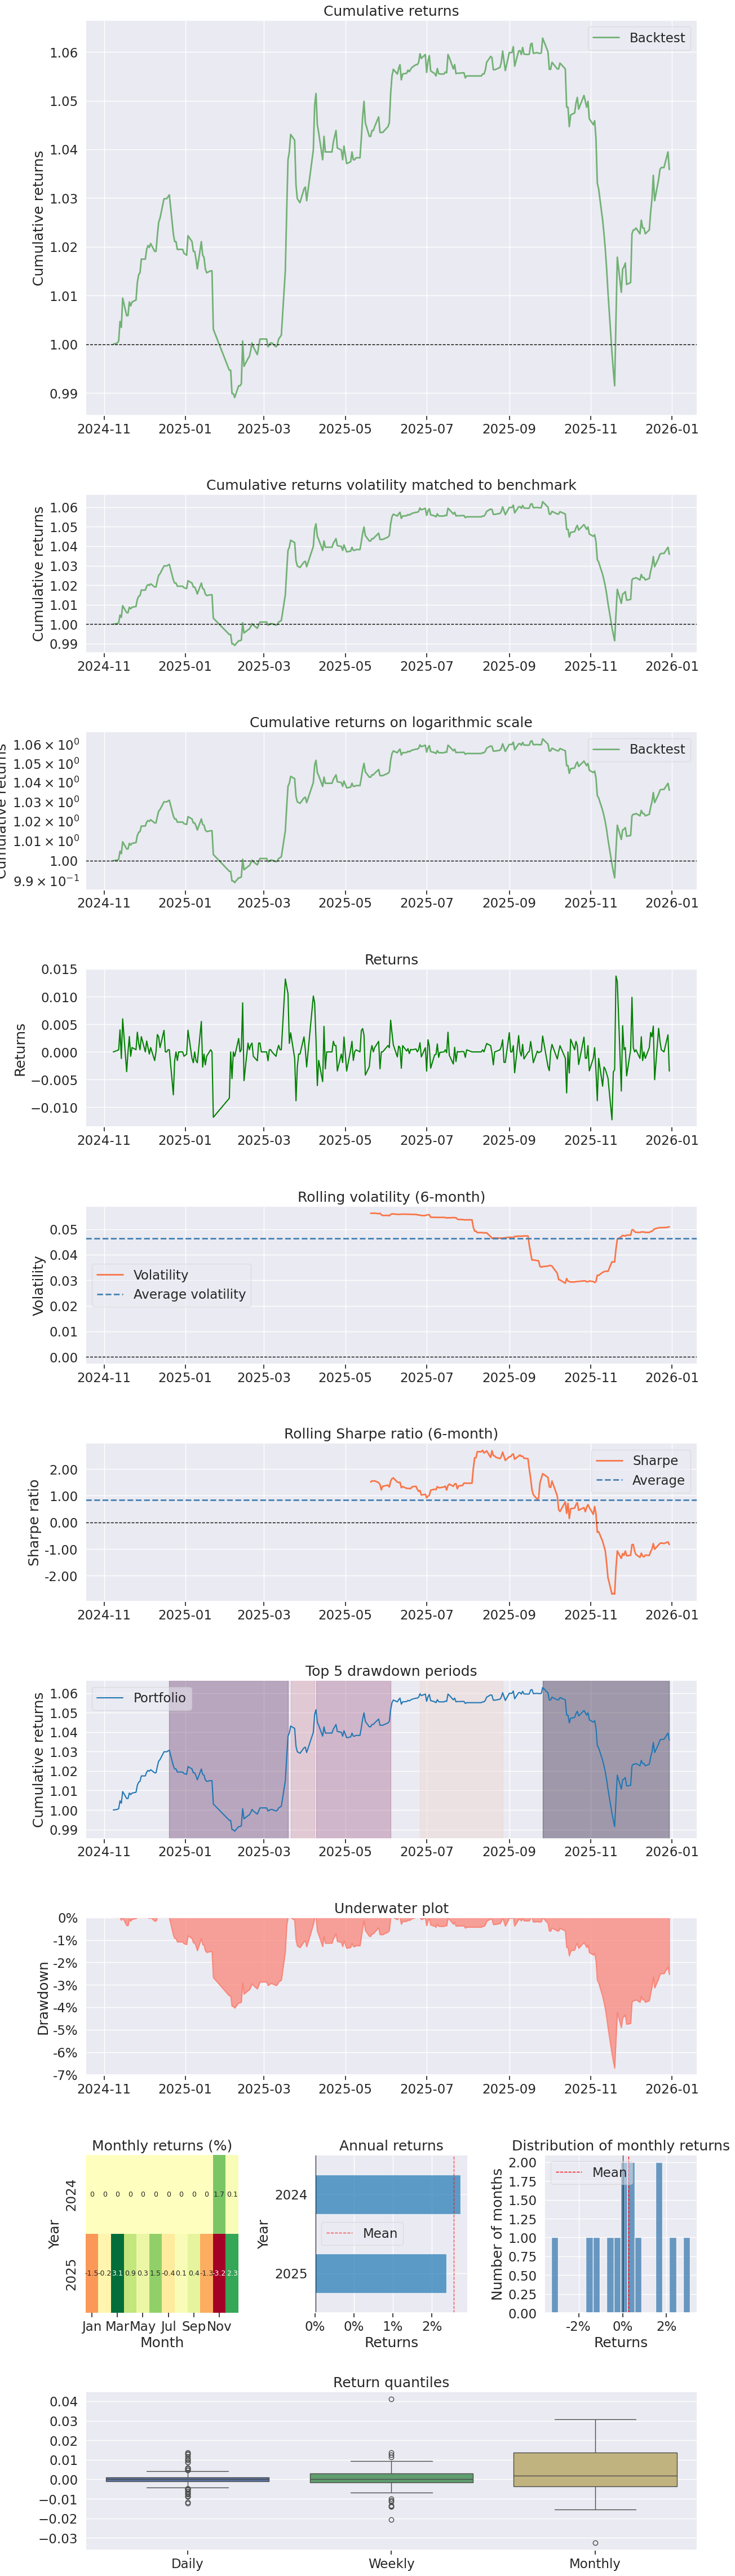

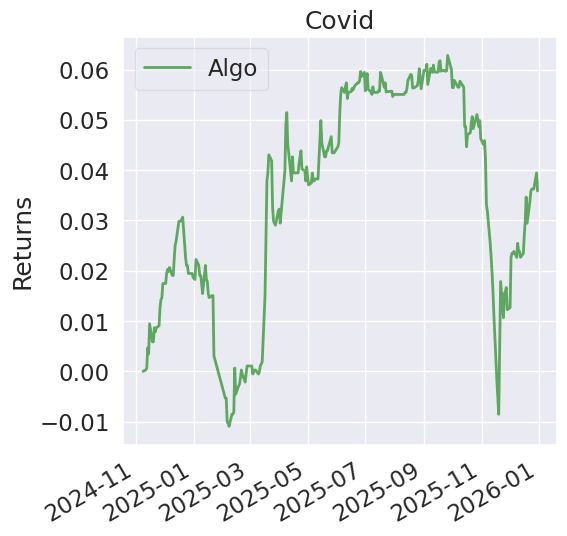

In [34]:
# 取得策略結果並生成投資組合分析報告
strat = results[0]  # 取得回測結果中的第一個策略
pyfoliozer = strat.analyzers.getbyname("pyfolio")
(
    returns,
    positions,
    transactions,
    gross_lev,
) = pyfoliozer.get_pf_items()
# 使用 PyFolio 生成完整的投資組合表現分析報告
pf.create_full_tear_sheet(returns)